데이터 읽어 오기

In [1]:
from os import listdir
from os.path import isfile, join

In [2]:
mypath = './final_data/'
listdir(mypath)

['biden_howard_university',
 'chatgpt_bard',
 'chatgpt_for_education',
 'covid19_south_korea',
 'covid19_vaccine_side_effects',
 'russia_ukraine_war',
 'self_driving_car_safety',
 'turkey_earthquake_damage']

In [3]:
total_docs=[]
total_file_names = []
for folder in listdir(mypath):
    folder_path = mypath+folder+'/'
    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    for file in onlyfiles:
        total_file_names.append(file)
        file_path = folder_path+file
        with open(file_path, 'r', encoding='utf8') as f:
            content = f.read()
        total_docs.append(content)

In [4]:
len(total_file_names)

208

In [5]:
len(total_docs)

208

In [6]:
total_file_names[:5]

['biden_howard-1.txt',
 'biden_howard-10.txt',
 'biden_howard-11.txt',
 'biden_howard-12.txt',
 'biden_howard-13.txt']

In [7]:
total_docs[1]

'President Joe Biden gave his commencement speech to Howard University’s Class of 2023 at D.C.’s Capital One Arena.\n\n“Today, I come here to Howard to continue the work to redeem the soul of this nation because it’s here where I see the future,” Biden said to the crowd.\n\nHe became the first sitting president since Barack Obama in 2016 and seventh U.S. president to speak at Howard University’s commencement.\n\nBiden along with Rep. Jim Clyburn received the honorary Doctor of Letters from a university that has been a main focus for the president and Vice President Kamala Harris, who is a Howard alum, during their time in office.\n\nDuring his speech, Biden called for unity and acceptance.\n\n“Love over hate, union over disunion, progress over retreat. To stand up against the poison of white supremacy as I did in my inaugural address to single out as the most dangerous terrorist threat to our homeland is white supremacy,” he said.\n\nBiden’s speech comes after his announcement of his 2

In [8]:
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
import networkx as nx
import itertools

# Step 1: To extract embedding vectors

## Using pre-trained BERT

In [9]:
# 기호 없애기
def remove_symbols(text):
    cleaned_content = re.sub(r'[^\w\d\s]','',text)
    return cleaned_content

In [10]:
# 각 문서의 기호 제거
cleaned_docs = [remove_symbols(doc) for doc in total_docs]

In [11]:
len(cleaned_docs)

208

In [12]:
cleaned_docs[:2]

['President Biden used a commencement address at Howard University to appeal to young Black voters offering a preview for how his campaign plans to regain waning enthusiasm from a key demographic\n\nSpeaking at the schools 155th commencement ceremony on Saturday the president echoed rhetoric from his 2020 campaign characterizing the current moment as a battle for the soul of our nation and calling on graduates to help lead the country into a new era of progress\n\nWere living through one of the most consequential eras of our history with fundamental questions about the stake for our nation he told the crowd at Capital One Arena in Washington DC Who are we What do we stand for What do we believe Who will we be Youre going to help answer those questions\n\nBiden also cast himself as the antidote to what he implied was a rising tolerance for racism directly mentioning Donald Trumps infamous characterization of the deadly white supremacist rally in Charlottesville as very fine people on bo

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [14]:
from transformers import TFBertModel, BertTokenizer

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [16]:
len(cleaned_docs[2].split())

392

In [17]:
tokenized_data = tokenizer(cleaned_docs, return_tensors="np", max_length=512, padding='max_length', truncation=True)

In [18]:
tokenized_data['input_ids'].shape

(208, 512)

In [19]:
model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [20]:
outputs = model(tokenized_data)

In [21]:
len(outputs)

3

In [22]:
# [CLS] 토큰에 대한 768 차원의 임베딩 벡터 사용
docs_features = outputs.last_hidden_state[:,0,:].numpy()

In [23]:
docs_features.shape

(208, 768)

## PCA를 이용한 문서 표현

### 각 문서를 명사 단어들을 이용해서 표현

In [24]:
def do_preprocessing(text, customized_stopwords):
    cleaned_content = re.sub(r'[^\w\d\s]','',text) # To remove symbols
    cleaned_content = cleaned_content.lower() # Case conversion, upper -> lower
    word_tokens = nltk.word_tokenize(cleaned_content) # Tokenization
    tokens_pos = nltk.pos_tag(word_tokens) # POS tagging
    NN_words = []   # To select nouns
    for word, pos in tokens_pos:
        if 'NN' in pos:
            NN_words.append(word)
            
    wlem = nltk.WordNetLemmatizer()   # Lemmatization
    lemmatized_words = []
    for word in NN_words:
        lemmatized_words.append(wlem.lemmatize(word))
    # 불용어 제거    
    stopwords_list = stopwords.words('english')
    unique_NN_words = set(lemmatized_words)
    final_NN_words = lemmatized_words
    for word in unique_NN_words:
        if word in stopwords_list:
            while word in final_NN_words: 
                final_NN_words.remove(word)
    
    unique_NN_words1 = set(final_NN_words)
    for word in unique_NN_words1:
        if word in customized_stopwords:
            while word in final_NN_words: 
                final_NN_words.remove(word)
    
    return final_NN_words

In [25]:
def get_words(counter_results):
    words = []
    for word, fre in counter_results:
        words.append(word)
    return words

In [26]:
def select_words(K, text, customized_stopwords):
    c = Counter(do_preprocessing(text, customized_stopwords))
    selected_words = get_words(c.most_common(K))
    return selected_words

In [27]:
customized_stopwords = ['york', 'time', 'news', 'mr', 'dr', 'mrs', 'st']

In [28]:
docs_nouns = [' '.join(do_preprocessing(doc, customized_stopwords)) for doc in total_docs]

In [29]:
len(docs_nouns)

208

In [30]:
print(docs_nouns[:2])

['president biden address howard university voter preview campaign plan enthusiasm speaking school commencement ceremony president rhetoric campaign moment battle soul nation graduate country era progress era history question stake nation crowd capital arena washington dc question antidote tolerance racism donald trump characterization supremacist rally charlottesville people side progress justice pushback sinister force thats hate day gut heart love unity disunion progress retreat poison supremacy bidens support voter victory address week reelection campaign video announcement campaign theme person government age hyperpartisanship disillusionment voter break field victory carolina sign work enthusiasm approval rating adult month office press part saturday administration chief achievement equality president record level judge woman court justice jackson funding college university thats short biden woman howard alum vice running mate', 'president joe biden commencement speech class capi

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
vectorizer = CountVectorizer()
DTM_tf = vectorizer.fit_transform(docs_nouns)
DTM = np.array(DTM_tf.todense())

In [33]:
DTM.shape

(208, 5377)

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=100)

In [45]:
pca_features = pca.fit_transform(DTM)

In [47]:
pca_features.shape

(208, 100)

### bert embedding + PCA embedding (concat)

In [52]:
total_features = np.concatenate((docs_features,pca_features), axis=1)

In [53]:
total_features.shape

(208, 868)

# 단계 2: 차원 축소 with UMAP

In [38]:
import umap

In [39]:
import matplotlib.pyplot as plt

전체 feature 이용 경우

In [54]:
reducer = umap.UMAP()
# https://umap-learn.readthedocs.io/en/latest/parameters.html
umap_embedding = reducer.fit_transform(total_features)
umap_embedding.shape

(208, 2)

In [101]:
umap_embedding[0]

array([ 7.104826 , -4.016259 ,  5.2430563], dtype=float32)

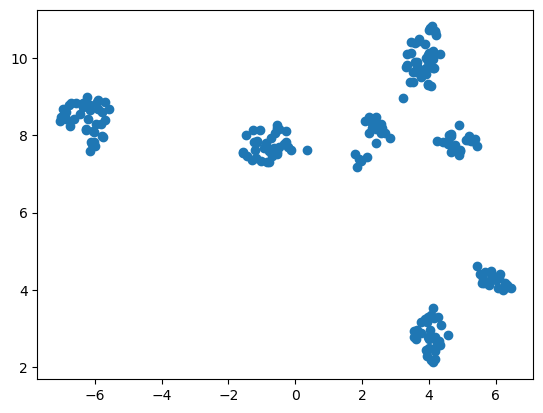

In [55]:
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1])

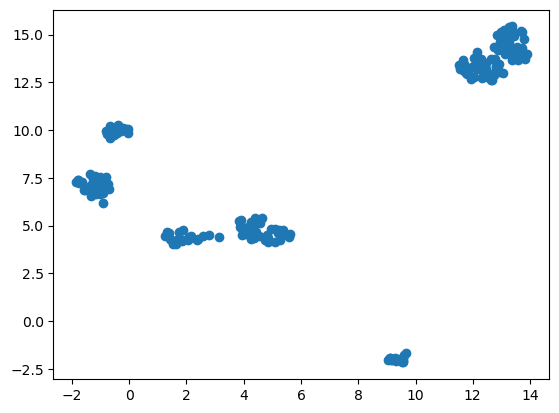

In [93]:
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1])

bert embedding 정보만 사용하는 경우

In [56]:
reducer1 = umap.UMAP()
umap_embedding1 = reducer1.fit_transform(docs_features)

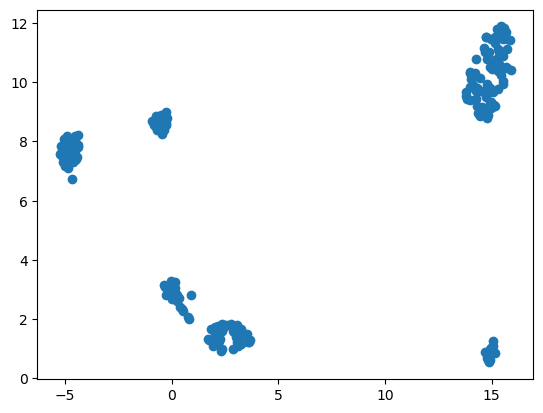

In [57]:
plt.scatter(
    umap_embedding1[:, 0],
    umap_embedding1[:, 1])

In [304]:
reducer1 = umap.UMAP()
umap_embedding1 = reducer1.fit_transform(docs_features)

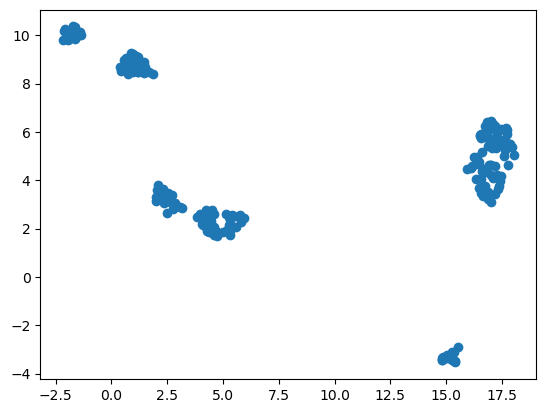

In [305]:
plt.scatter(
    umap_embedding1[:, 0],
    umap_embedding1[:, 1])

In [49]:
pca_features.shape

(208, 100)

In [50]:
reducer2 = umap.UMAP()
umap_embedding2 = reducer2.fit_transform(pca_features)

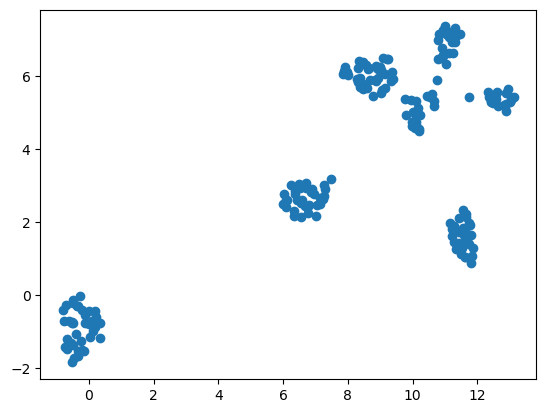

In [51]:
plt.scatter(
    umap_embedding2[:, 0],
    umap_embedding2[:, 1])

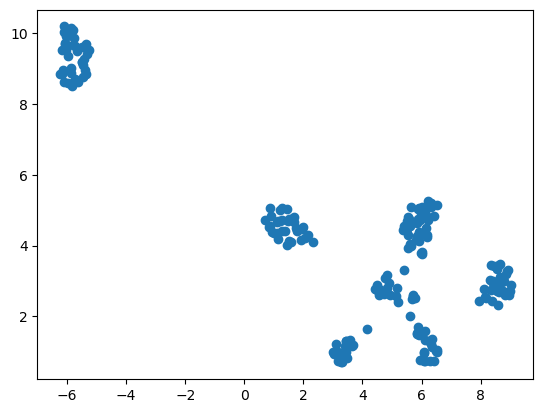

In [44]:
plt.scatter(
    umap_embedding2[:, 0],
    umap_embedding2[:, 1])

# 단계 3: 군집화 using HDBSCAN

In [58]:
import hdbscan

In [59]:
clusterer = hdbscan.HDBSCAN()

In [60]:
clusterer.fit(umap_embedding)

HDBSCAN()

In [61]:
clusterer.labels_

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 5, 5, 5, 5, 1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [62]:
# 문서 정보만을 사용
reducer1 = umap.UMAP()
umap_embedding1 = reducer1.fit_transform(docs_features)
clusterer1 = hdbscan.HDBSCAN()
clusterer1.fit(umap_embedding1)
clusterer1.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [63]:
# pca_embedding 만을 사용
clusterer2 = hdbscan.HDBSCAN()
clusterer2.fit(umap_embedding2)
clusterer2.labels_

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 1, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)

In [64]:
cluster_numbers = list(range(clusterer.labels_.max()+1))

In [65]:
cluster_numbers

[0, 1, 2, 3, 4, 5, 6]

In [91]:
from collections import defaultdict

In [92]:
clusters_docs_dict = defaultdict(str)

In [93]:
for k in cluster_numbers:
    for idx, cls in enumerate(clusterer.labels_):
#         print(idx,cls)
        clusters_docs_dict[cls]+= docs_nouns[idx]
        

In [94]:
clusters_docs_dict.keys()

dict_keys([5, 0, 1, 2, 6, 3, 4])

In [95]:
c1=Counter(clusters_docs_dict[0].split())

In [96]:
c1['biden']

0

단어-군집 행렬 생성, 각 셀의 값은 tft,c (이 값은 BERTopic 논문 참고)

In [97]:
total_nouns_docs = []
for key in clusters_docs_dict:
    total_nouns_docs.append(clusters_docs_dict[key])

In [98]:
len(total_nouns_docs)

7

In [99]:
vectorizer = CountVectorizer()
CTM_tf = vectorizer.fit_transform(total_nouns_docs)
CTM = np.array(CTM_tf.todense())

In [100]:
CTM.shape

(7, 5559)

In [101]:
TCM = CTM.T

In [102]:
TCM.shape # it must be (5558,6)

(5559, 7)

In [103]:
TCM

array([[  0,   0,   0, ...,   7,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  7,  91, 147, ...,  14,   7,   0],
       ...,
       [  0,   0,   0, ...,   7,   0,   7],
       [  0,   0,   0, ...,   0,   0,   7],
       [  0,   0,   0, ...,   0,   0,   7]], dtype=int64)

In [104]:
clusters_docs_dict[0]

'google battle wit field intelligence bard service popularity chatgpt tool bard group tester year blog post google ceo sundar pichai google subject space discovery term child service task tip party lunch idea food refrigerator pichai didnt post bard prose vein william shakespeare playwright service outlet creativity launchpad curiosity pichai google bard existence week microsoft billion dollar openai san maker chatgpt tool text image decision ante investment openai pressure google pace field technology analyst computer internet smartphones stage year report week cnbc team google engineer intelligence technology response bard service project atlas part google code effort success chatgpt ten million user release year concern school ability essay student pichai importance intelligence year byproduct part system language model dialogue application lamda power bard google lamda intelligence advancement search engine answer question user timeline pichai intelligence tool google future sign g

In [105]:
total_num_nouns = 0
for key in clusters_docs_dict:
    print(len(clusters_docs_dict[key].split()))
    total_num_nouns += len(clusters_docs_dict[key].split())

21680
44815
58815
51857
60831
26629
20833


In [106]:
avg_num_nouns_per_class = total_num_nouns/len(clusters_docs_dict.keys())

In [107]:
avg_num_nouns_per_class

40780.0

In [109]:
Nouns = []
for doc in total_nouns_docs:
    Nouns.extend(doc.split())

In [110]:
len(set(Nouns))

5569

In [111]:
c2 = Counter(Nouns)

In [112]:
feature_names = vectorizer.get_feature_names_out()

In [113]:
len(feature_names)

5559

In [114]:
tf_t = []

In [115]:
for word in feature_names:
    tf_t.append(c2[word])

In [116]:
len(tf_t)

5559

In [117]:
tf_t=np.asarray(tf_t)

In [118]:
tf_t.shape

(5559,)

In [119]:
inv_tf_t = np.reciprocal(tf_t.astype(float)+1)

In [120]:
final_right_term = np.log(1+inv_tf_t*avg_num_nouns_per_class)

In [121]:
final_right_term.shape

(5559,)

In [122]:
TCM[:5]

array([[  0,   0,   0,   0,   7,   0,   0],
       [  0,   0,   0,   7,   0,   0,   0],
       [  7,  91, 147,  84,  14,   7,   0],
       [  7,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  14,   0,   0]], dtype=int64)

In [123]:
final_right_term[:5]

array([8.53670166, 8.53670166, 4.76373115, 8.53670166, 7.9082646 ])

In [178]:
#(m.T * c).T

In [181]:
TCM[2]*final_right_term[2]

array([  29.49714445, 1002.90291132,  353.96573341,   29.49714445,
         58.9942889 ,    0.        ])

In [124]:
TCM_Wtc=(TCM.T*final_right_term).T

In [125]:
TCM_Wtc.shape

(5559, 7)

In [126]:
TCM_Wtc[:5]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
         59.7569116 ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  59.7569116 ,
          0.        ,   0.        ,   0.        ],
       [ 33.34611805, 433.49953471, 700.26847914, 400.15341665,
         66.69223611,  33.34611805,   0.        ],
       [ 59.7569116 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        110.71570444,   0.        ,   0.        ]])

In [127]:
from sklearn.preprocessing import normalize

In [128]:
TCM_Wtc_normed = normalize(TCM_Wtc, axis=1, norm='l2')

In [129]:
TCM_Wtc_normed[:5]

array([[0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        ],
       [0.03627381, 0.47155956, 0.76175006, 0.43528575, 0.07254763,
        0.03627381, 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ]])

In [130]:
len(docs_nouns)

208

In [131]:
feature_names

array(['1940s', '30yearolds', 'ability', ..., 'çavuşoğlu', 'şahinbey',
       'şirvani'], dtype=object)

In [132]:
words_dict2={}
for k, word in enumerate(feature_names):
    words_dict2[word]=k

In [133]:
len(words_dict2.keys())

5559

## 각 문서별 주제 분포 구하기

문서 1에 대한 문서-주제 분포 구하기

In [138]:
doc1_final = np.zeros(7)

In [139]:
doc1_final

array([0., 0., 0., 0., 0., 0., 0.])

In [140]:
TCM_Wtc_normed[0] # 첫 번째 단어에 대한 주제별 확률

array([0., 0., 0., 0., 1., 0., 0.])

In [141]:
TCM_Wtc_normed[2]+doc1_final

array([0.03627381, 0.47155956, 0.76175006, 0.43528575, 0.07254763,
       0.03627381, 0.        ])

각 단어가 각 주제와 관련된 정도를 더한다.

In [144]:
docs_nouns

['president biden address howard university voter preview campaign plan enthusiasm speaking school commencement ceremony president rhetoric campaign moment battle soul nation graduate country era progress era history question stake nation crowd capital arena washington dc question antidote tolerance racism donald trump characterization supremacist rally charlottesville people side progress justice pushback sinister force thats hate day gut heart love unity disunion progress retreat poison supremacy bidens support voter victory address week reelection campaign video announcement campaign theme person government age hyperpartisanship disillusionment voter break field victory carolina sign work enthusiasm approval rating adult month office press part saturday administration chief achievement equality president record level judge woman court justice jackson funding college university thats short biden woman howard alum vice running mate',
 'president joe biden commencement speech class cap

In [145]:
for word in docs_nouns[0].split():
    print(word)
    doc1_final+=TCM_Wtc_normed[words_dict2[word]]
    print(word, TCM_Wtc_normed[words_dict2[word]])
    print(doc1_final)

president
president [0.54463957 0.08730863 0.05820576 0.17461727 0.80517961 0.
 0.11641151]
[0.54463957 0.08730863 0.05820576 0.17461727 0.80517961 0.
 0.11641151]
biden
biden [0.92734119 0.         0.         0.01384091 0.37370466 0.
 0.01384091]
[1.47198076 0.08730863 0.05820576 0.18845818 1.17888427 0.
 0.13025242]
address
address [0.97192739 0.08451543 0.         0.04225771 0.21128856 0.04225771
 0.        ]
[2.44390815 0.17182406 0.05820576 0.23071589 1.39017283 0.04225771
 0.13025242]
howard
howard [0.99861783 0.         0.         0.05255883 0.         0.
 0.        ]
[3.44252598 0.17182406 0.05820576 0.28327472 1.39017283 0.04225771
 0.13025242]
university
university [0.65337728 0.         0.71277522 0.22274226 0.07424742 0.04454845
 0.0890969 ]
[4.09590326 0.17182406 0.77098097 0.50601698 1.46442025 0.08680616
 0.21934933]
voter
voter [0.98787834 0.         0.         0.10976426 0.         0.
 0.10976426]
[5.0837816  0.17182406 0.77098097 0.61578124 1.46442025 0.08680616
 0.32

KeyError: 'mate'

In [146]:
doc1_final

array([78.87230277, 15.02312591, 16.25739526, 22.16994855, 33.09505608,
       10.2488182 ,  7.39581055])

In [147]:
# normalize 하기
doc1_final/np.sum(doc1_final)

array([0.43084914, 0.08206558, 0.08880792, 0.12110593, 0.1807856 ,
       0.05598536, 0.04040048])

위의 결과는 문서1의 경우, 주제 0과 가장 관련이 높다는 것을 의미한다.

주제 0과 관련이 높은 단어들 구하기

In [148]:
# TCM_Wtc를 열을 기준으로 normalize하기 
topic0_words_dist=TCM_Wtc[:,0]/np.sum(TCM_Wtc[:,0])

In [149]:
topic0_words_dist.sum()

0.9999999999999999

In [150]:
topic0_words_prob = {}

In [151]:
for idx, word in enumerate(feature_names):
    topic0_words_prob[word]=topic0_words_dist[idx]

In [152]:
topic0_words_prob

{'1940s': 0.0,
 '30yearolds': 0.0,
 'ability': 0.00026735435157681744,
 'abortion': 0.0004791043541639955,
 'abramovich': 0.0,
 'absence': 0.0,
 'abstention': 0.0,
 'abstract': 0.0,
 'abuse': 0.0,
 'abyss': 0.0,
 'academia': 0.0,
 'academic': 0.0,
 'academy': 0.0018815617503788443,
 'accelerate': 0.0004791043541639955,
 'acceleration': 0.0,
 'accentuate': 0.0,
 'acceptance': 0.00044383465147804907,
 'accepts': 0.0,
 'access': 0.0002471481439255735,
 'accessibility': 0.0,
 'accessopens': 0.0,
 'accident': 0.0033804229469787577,
 'accolade': 0.0,
 'accommodation': 0.0,
 'accomplishment': 0.0008446992986803823,
 'accord': 0.0,
 'accordance': 0.0,
 'account': 0.0,
 'accountability': 0.0,
 'accounting': 0.0,
 'accuracy': 0.0,
 'accurate': 0.0,
 'accusation': 0.0004791043541639955,
 'acetaminophen': 0.0,
 'ache': 0.0,
 'achievement': 0.0004791043541639955,
 'achiness': 0.0,
 'achy': 0.0,
 'acid': 0.0,
 'acquaintance': 0.0,
 'acquisition': 0.0,
 'acronym': 0.0004791043541639955,
 'act': 0.000

In [153]:
{k: v for k, v in sorted(topic0_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'car': 0.017602425909621546,
 'biden': 0.015494306207511912,
 'president': 0.01097991573776624,
 'vehicle': 0.010181629182550177,
 'university': 0.009615001132753228,
 'graduate': 0.007895614708146814,
 'supremacy': 0.007895614708146814,
 'commencement': 0.0076464202773077325,
 'nation': 0.007167296173841631,
 'system': 0.00687154864026178,
 'address': 0.006719201933769702,
 'driver': 0.0065336739826721115,
 'howard': 0.00604679990365435,
 'threat': 0.006007474226695827,
 'road': 0.0057300265001192,
 'soul': 0.005563669083917271,
 'hate': 0.005509739951929092,
 'speech': 0.0054284461580076625,
 'year': 0.004943071540475542,
 'class': 0.004912649329270381,
 'safety': 0.004912649329270381,
 'racism': 0.004732592125770261,
 'life': 0.004695814734585896,
 'battle': 0.004594560648987041,
 'people': 0.004486115920912975,
 'administration': 0.004435882670097863,
 'selfdriving': 0.004394549831072386,
 'hope': 0.004251484842848284,
 'cummings': 0.004158960583548003,
 'graduation': 0.0041589605

In [167]:
list({k: v for k, v in sorted(topic0_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['car', 'biden', 'president', 'vehicle', 'university', 'graduate']

주제 1과 관련 높은 단어들 구하기

In [154]:
# TCM_Wtc를 열을 기준으로 normalize하기 
topic1_words_dist=TCM_Wtc[:,1]/np.sum(TCM_Wtc[:,1])
topic1_words_prob = {}
for idx, word in enumerate(feature_names):
    topic1_words_prob[word]=topic1_words_dist[idx]

In [155]:
{k: v for k, v in sorted(topic1_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'google': 0.031074698495023544,
 'bard': 0.02883769098784211,
 'search': 0.015885565071359697,
 'ai': 0.013838864590254627,
 'user': 0.013806741679239912,
 'chatbot': 0.013643543055660876,
 'chatgpt': 0.011073760157108932,
 'model': 0.010906165696206315,
 'language': 0.010825718419000685,
 'company': 0.01066260087543245,
 'engine': 0.00919437569117175,
 'technology': 0.00795886627491355,
 'information': 0.00793945365672139,
 'product': 0.007841259995139032,
 'response': 0.007645414720962329,
 'pichai': 0.0075541477677976455,
 'answer': 0.007517191109183413,
 'question': 0.0062642337567213255,
 'post': 0.006048607603588822,
 'intelligence': 0.0057530845748853966,
 'microsoft': 0.00569100267457791,
 'blog': 0.005517357653985356,
 'lamda': 0.005416050072936078,
 'year': 0.005251495038837905,
 'access': 0.005167580986309697,
 'chatbots': 0.005016045785688119,
 'openai': 0.004925456100507992,
 'month': 0.004837709769408317,
 'week': 0.004649785845658594,
 'internet': 0.004610939122739853,


In [166]:
list({k: v for k, v in sorted(topic1_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['google', 'bard', 'search', 'ai', 'user', 'chatbot']

주제 2와 관련 높은 단어들 확인하기

In [156]:
topic2_words_dist=TCM_Wtc[:,2]/np.sum(TCM_Wtc[:,2])
topic2_words_prob = {}
for idx, word in enumerate(feature_names):
    topic2_words_prob[word]=topic2_words_dist[idx]
{k: v for k, v in sorted(topic2_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'student': 0.025654157430379854,
 'chatgpt': 0.020926064401506322,
 'tool': 0.013834315681245872,
 'teacher': 0.012908740397515604,
 'ai': 0.012056243699277106,
 'education': 0.01074440156181514,
 'technology': 0.010285281935175016,
 'school': 0.009404664700116845,
 'educator': 0.008586836111484955,
 'essay': 0.006279456447019766,
 'question': 0.006029383688744872,
 'way': 0.00597631855873257,
 'classroom': 0.0056283442418417215,
 'class': 0.004932361043695806,
 'answer': 0.004647013087797776,
 'intelligence': 0.004534795706338383,
 'learning': 0.004519712310349819,
 'example': 0.004307926228147807,
 'university': 0.004298440410496099,
 'language': 0.004266617391548653,
 'use': 0.004170802681810908,
 'skill': 0.004053217376251686,
 'text': 0.0039224218405683724,
 'assessment': 0.003918545056048401,
 'model': 0.003786182530653192,
 'work': 0.0036858256257863834,
 'concern': 0.0036808816160340757,
 'bot': 0.0036104215062073685,
 'assignment': 0.0035144696655732086,
 'paper': 0.003511112

In [168]:
list({k: v for k, v in sorted(topic2_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['student', 'chatgpt', 'tool', 'teacher', 'ai', 'education']

주제 3

In [157]:
topic3_words_dist=TCM_Wtc[:,3]/np.sum(TCM_Wtc[:,3])
topic3_words_prob = {}
for idx, word in enumerate(feature_names):
    topic3_words_prob[word]=topic3_words_dist[idx]
{k: v for k, v in sorted(topic3_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'korea': 0.018912290996509627,
 'case': 0.01700161016327205,
 'country': 0.01275342215615064,
 'government': 0.01217503979756642,
 'people': 0.012033641976349162,
 'coronavirus': 0.011261729478235559,
 'outbreak': 0.01087873718597077,
 'health': 0.01020068917817928,
 'virus': 0.0100442452103182,
 'infection': 0.009328702995637076,
 'patient': 0.009002591955549923,
 'test': 0.00871246551844477,
 'day': 0.008032558469279314,
 'number': 0.00785995878372259,
 'disease': 0.007122321502464398,
 'authority': 0.006851087557773258,
 'covid19': 0.005614737863274818,
 'control': 0.005564473442110894,
 'south': 0.005438078221672462,
 'week': 0.005329775588562722,
 'measure': 0.005309131235145358,
 'information': 0.005235920219635777,
 'city': 0.005234077669154491,
 'response': 0.004802359023980124,
 'contact': 0.0047474862766648295,
 'official': 0.004527753187344388,
 'march': 0.004432992816307188,
 'china': 0.004408413714330883,
 'world': 0.004260976541268298,
 'citizen': 0.004248171225514521,
 

In [158]:
list({k: v for k, v in sorted(topic3_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['korea', 'case', 'country', 'government', 'people', 'coronavirus']

주제 4

In [159]:
topic4_words_dist=TCM_Wtc[:,4]/np.sum(TCM_Wtc[:,4])
topic4_words_prob = {}
for idx, word in enumerate(feature_names):
    topic4_words_prob[word]=topic4_words_dist[idx]
{k: v for k, v in sorted(topic4_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'war': 0.015649770611197128,
 'russia': 0.01548586500316466,
 'ukraine': 0.010106545409986201,
 'putin': 0.008557023693180527,
 'force': 0.007011176302969014,
 'invasion': 0.0066221345222125605,
 'country': 0.006574518389917858,
 'president': 0.0058875761923570195,
 'city': 0.005887025652985595,
 'state': 0.005184751195086399,
 'world': 0.00494229734143553,
 'civilian': 0.00492518979339043,
 'moscow': 0.0048485425671422324,
 'europe': 0.004800810674244697,
 'west': 0.004576740193031387,
 'kyiv': 0.004537866364819067,
 'union': 0.004502524738120016,
 'security': 0.004363688310428009,
 'people': 0.004271237791561245,
 'leader': 0.004162824694789394,
 'conflict': 0.004107284184692255,
 'sanction': 0.004038664126889845,
 'troop': 0.003937697523717598,
 'mariupol': 0.003894900696156232,
 'zelenskyy': 0.0034762292361220585,
 'oil': 0.0033046105015220096,
 'power': 0.003115842625897826,
 'weapon': 0.0030548681165921123,
 'kremlin': 0.0030422504818891248,
 'talk': 0.0030040173091660256,
 'chi

In [160]:
list({k: v for k, v in sorted(topic4_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['war', 'russia', 'ukraine', 'putin', 'force', 'invasion']

주제 5

In [161]:
topic5_words_dist=TCM_Wtc[:,5]/np.sum(TCM_Wtc[:,5])
topic5_words_prob = {}
for idx, word in enumerate(feature_names):
    topic5_words_prob[word]=topic5_words_dist[idx]
{k: v for k, v in sorted(topic5_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'vaccine': 0.04964891881728608,
 'effect': 0.03066037531040613,
 'side': 0.022985431670582975,
 'covid19': 0.018252226135039906,
 'vaccination': 0.01737963618815666,
 'reaction': 0.014388754966682307,
 'people': 0.013126787656397325,
 'pain': 0.011683291861548909,
 'johnson': 0.009549381261768294,
 'symptom': 0.009162298063528179,
 'dose': 0.00879816761710647,
 'injection': 0.008581784617491437,
 'body': 0.007960815219721244,
 'immune': 0.007922868163646872,
 'source': 0.0077315391891907516,
 'shot': 0.00764966581317629,
 'day': 0.0072556125822463196,
 'headache': 0.007248092420729871,
 'trial': 0.0072408807710083985,
 'fever': 0.007198500777632566,
 'site': 0.007189743393940886,
 'arm': 0.00704094842981242,
 'response': 0.006713343679107585,
 'risk': 0.006704120534288912,
 'blood': 0.006690546849904497,
 'muscle': 0.006555601628740845,
 'chill': 0.005843052214011389,
 'health': 0.005703924415056765,
 'moderna': 0.005600577019896851,
 'disease': 0.00557562885411418,
 'dos': 0.00535540

In [162]:
list({k: v for k, v in sorted(topic5_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['vaccine', 'effect', 'side', 'covid19', 'vaccination', 'reaction']

주제 6

In [163]:
topic6_words_dist=TCM_Wtc[:,6]/np.sum(TCM_Wtc[:,6])
topic6_words_prob = {}
for idx, word in enumerate(feature_names):
    topic6_words_prob[word]=topic6_words_dist[idx]
{k: v for k, v in sorted(topic6_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'earthquake': 0.029722739762533753,
 'turkey': 0.027727832187270943,
 'building': 0.017006339824191113,
 'quake': 0.016514569548783047,
 'damage': 0.01647922707237286,
 'bank': 0.01288596769688909,
 'disaster': 0.009185188663942747,
 'cost': 0.008150095690802583,
 'magnitude': 0.008017489093550314,
 'syria': 0.007966083756221393,
 'election': 0.007046718189764097,
 'construction': 0.0069636618981803785,
 'world': 0.0068941690104462345,
 'area': 0.006882462975764889,
 'people': 0.0068396401495985516,
 'year': 0.006645364501352322,
 'reconstruction': 0.006555801925840544,
 'government': 0.0062313018639877414,
 'region': 0.0062269770850839025,
 'province': 0.005948491290352083,
 'country': 0.005861169554627115,
 'loss': 0.005558430463205078,
 'inflation': 0.0053770562641315385,
 'recovery': 0.005270765144120174,
 'vinton': 0.005130967961018871,
 'infrastructure': 0.005009255823454385,
 'home': 0.00486803224104699,
 'economy': 0.0047231528654703425,
 'aftershock': 0.004509049784604459,
 '

In [165]:
list({k: v for k, v in sorted(topic6_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['earthquake', 'turkey', 'building', 'quake', 'damage', 'bank']

# Topic coherence 구하기

In [169]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [170]:
topics = [['car', 'biden', 'president', 'vehicle', 'university', 'graduate'],
['google', 'bard', 'search', 'ai', 'user', 'chatbot'],
['student', 'chatgpt', 'tool', 'teacher', 'ai', 'education'],
['korea', 'case', 'country', 'government', 'people', 'coronavirus'],
['war', 'russia', 'ukraine', 'putin', 'force', 'invasion'],
['vaccine', 'effect', 'side', 'covid19', 'vaccination', 'reaction'],
['earthquake', 'turkey', 'building', 'quake', 'damage', 'bank']]

In [171]:
len(topics)

7

In [173]:
docs_nouns_split = [doc.split() for doc in docs_nouns]

In [174]:
docs_nouns_split[0]

['president',
 'biden',
 'address',
 'howard',
 'university',
 'voter',
 'preview',
 'campaign',
 'plan',
 'enthusiasm',
 'speaking',
 'school',
 'commencement',
 'ceremony',
 'president',
 'rhetoric',
 'campaign',
 'moment',
 'battle',
 'soul',
 'nation',
 'graduate',
 'country',
 'era',
 'progress',
 'era',
 'history',
 'question',
 'stake',
 'nation',
 'crowd',
 'capital',
 'arena',
 'washington',
 'dc',
 'question',
 'antidote',
 'tolerance',
 'racism',
 'donald',
 'trump',
 'characterization',
 'supremacist',
 'rally',
 'charlottesville',
 'people',
 'side',
 'progress',
 'justice',
 'pushback',
 'sinister',
 'force',
 'thats',
 'hate',
 'day',
 'gut',
 'heart',
 'love',
 'unity',
 'disunion',
 'progress',
 'retreat',
 'poison',
 'supremacy',
 'bidens',
 'support',
 'voter',
 'victory',
 'address',
 'week',
 'reelection',
 'campaign',
 'video',
 'announcement',
 'campaign',
 'theme',
 'person',
 'government',
 'age',
 'hyperpartisanship',
 'disillusionment',
 'voter',
 'break',
 '

In [238]:
word2id = Dictionary(docs_nouns_split)

In [245]:
cm = CoherenceModel(topics=topics, 
                    texts=docs_nouns_split,
                    coherence='c_uci',  
                    dictionary=word2id)

In [246]:
coherence_per_topic = cm.get_coherence_per_topic()

In [247]:
coherence_per_topic

[-8.005443040597587,
 1.416615459127431,
 1.1530978156581349,
 0.9295009025610871,
 1.5429206221929266,
 2.0910368146120097,
 2.3195676185140575]

In [248]:
# 최종값 
# https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

In [249]:
np.mean(np.asarray(coherence_per_topic))

0.20675659886686568

## BERT 임베딩 정보만을 사용하는 경우

In [180]:
cluster_numbers = list(range(clusterer1.labels_.max()+1))

In [181]:
cluster_numbers

[0, 1, 2, 3, 4, 5]

In [182]:
clusters_docs_dict = defaultdict(str)
for k in cluster_numbers:
    for idx, cls in enumerate(clusterer1.labels_):
#         print(idx,cls)
        clusters_docs_dict[cls]+= docs_nouns[idx]

In [183]:
clusters_docs_dict.keys()

dict_keys([1, 0, 3, 2, 5, 4])

In [184]:
total_nouns_docs = []
for key in clusters_docs_dict:
    total_nouns_docs.append(clusters_docs_dict[key])

In [185]:
len(total_nouns_docs)

6

In [186]:
vectorizer = CountVectorizer()
CTM_tf = vectorizer.fit_transform(total_nouns_docs)
CTM = np.array(CTM_tf.todense())

In [187]:
CTM.shape

(6, 5558)

In [188]:
TCM = CTM.T
TCM.shape # it must be (5558,5)

(5558, 6)

In [190]:
total_num_nouns = 0
for key in clusters_docs_dict:
    print(len(clusters_docs_dict[key].split()))
    total_num_nouns += len(clusters_docs_dict[key].split())
#     print(total_num_nouns)

12517
94891
46951
22825
50401
17095


In [191]:
len(clusters_docs_dict.keys())

6

In [192]:
total_num_nouns

244680

In [193]:
avg_num_nouns_per_class = total_num_nouns/len(clusters_docs_dict.keys())
avg_num_nouns_per_class

40780.0

In [194]:
print(total_nouns_docs)

['president biden address howard university voter preview campaign plan enthusiasm speaking school commencement ceremony president rhetoric campaign moment battle soul nation graduate country era progress era history question stake nation crowd capital arena washington dc question antidote tolerance racism donald trump characterization supremacist rally charlottesville people side progress justice pushback sinister force thats hate day gut heart love unity disunion progress retreat poison supremacy bidens support voter victory address week reelection campaign video announcement campaign theme person government age hyperpartisanship disillusionment voter break field victory carolina sign work enthusiasm approval rating adult month office press part saturday administration chief achievement equality president record level judge woman court justice jackson funding college university thats short biden woman howard alum vice running matepresident joe biden commencement speech class capital 

In [195]:
Nouns = []
for doc in total_nouns_docs:
    Nouns.extend(doc.split())

In [196]:
len(set(Nouns))

5568

In [197]:
feature_names = vectorizer.get_feature_names_out()

In [198]:
c2 = Counter(Nouns)

In [199]:
tf_t = []
for word in feature_names:
    tf_t.append(c2[word])

In [200]:
tf_t=np.asarray(tf_t)

In [201]:
inv_tf_t = np.reciprocal(tf_t.astype(float)+1)

In [202]:
final_right_term = np.log(1+inv_tf_t*avg_num_nouns_per_class)

In [203]:
TCM_Wtc=(TCM.T*final_right_term).T

In [204]:
TCM_Wtc.shape

(5558, 6)

In [205]:
TCM_Wtc_normed = normalize(TCM_Wtc, axis=1, norm='l2')

In [206]:
words_dict2={}
for k, word in enumerate(feature_names):
    words_dict2[word]=k

In [207]:
topic0_words_dist=TCM_Wtc[:,0]/np.sum(TCM_Wtc[:,0])
topic0_words_prob = {}
for idx, word in enumerate(feature_names):
    topic0_words_prob[word]=topic0_words_dist[idx]
{k: v for k, v in sorted(topic0_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'biden': 0.023109805752305302,
 'president': 0.016480189585789975,
 'university': 0.014041978813307841,
 'graduate': 0.011678831119911318,
 'supremacy': 0.011678831119911318,
 'commencement': 0.01130799968227497,
 'nation': 0.010666806884024629,
 'address': 0.009949547182182604,
 'threat': 0.0089370659610891,
 'howard': 0.008932721741833962,
 'soul': 0.008212893706919239,
 'hate': 0.008135383709464454,
 'speech': 0.008031053504310178,
 'class': 0.007312747016693903,
 'racism': 0.006980171628215262,
 'battle': 0.006806804561673944,
 'hope': 0.00628860137225994,
 'graduation': 0.006130170485525082,
 'hbcu': 0.006130170485525082,
 'violence': 0.006012922809701626,
 'ceremony': 0.0059830042527559395,
 'joe': 0.005966763962061256,
 'life': 0.00551731390552998,
 'progress': 0.005507782118825776,
 'history': 0.005353076829572755,
 'year': 0.005337621631721726,
 'america': 0.005314225339771272,
 'administration': 0.005252977730868579,
 'rock': 0.005177602682438563,
 'woman': 0.005080057251345

In [228]:
list({k: v for k, v in sorted(topic0_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:10]

['biden',
 'president',
 'university',
 'graduate',
 'supremacy',
 'commencement',
 'nation',
 'address',
 'threat',
 'howard']

In [209]:
topic1_words_dist=TCM_Wtc[:,1]/np.sum(TCM_Wtc[:,1])
topic1_words_prob = {}
for idx, word in enumerate(feature_names):
    topic1_words_prob[word]=topic1_words_dist[idx]
{k: v for k, v in sorted(topic1_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'chatgpt': 0.01599826536338029,
 'student': 0.014287204128629691,
 'google': 0.01314789486702652,
 'ai': 0.01217253180318923,
 'bard': 0.011628934474069623,
 'technology': 0.00927360418308789,
 'tool': 0.00901191120021799,
 'chatbot': 0.0072939644200384,
 'teacher': 0.007033479632188168,
 'search': 0.006689321298820087,
 'language': 0.006596414058558697,
 'model': 0.006507336067339112,
 'user': 0.006507336067339112,
 'question': 0.0059871354318166755,
 'education': 0.005894349760868853,
 'company': 0.005889536488229765,
 'answer': 0.005585561225602689,
 'school': 0.005167198066631343,
 'information': 0.004994914121660563,
 'intelligence': 0.004778986205730499,
 'response': 0.0047131906755893856,
 'educator': 0.004654816931724693,
 'way': 0.004342217156210831,
 'car': 0.003965104360449046,
 'essay': 0.0039468073342100885,
 'engine': 0.0037737196201155197,
 'system': 0.003762743230586299,
 'year': 0.0037122016646194953,
 'product': 0.003565285880405807,
 'example': 0.003477862022840886,

In [210]:
list({k: v for k, v in sorted(topic1_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['chatgpt', 'student', 'google', 'ai', 'bard', 'technology']

In [211]:
TCM_Wtc.shape

(5558, 6)

In [212]:
topic2_words_dist=TCM_Wtc[:,2]/np.sum(TCM_Wtc[:,2])
topic2_words_prob = {}
for idx, word in enumerate(feature_names):
    topic2_words_prob[word]=topic2_words_dist[idx]
{k: v for k, v in sorted(topic2_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'korea': 0.01815014974861071,
 'case': 0.016417190140652977,
 'country': 0.012400089971696693,
 'government': 0.011881324951510952,
 'people': 0.011753129096739251,
 'coronavirus': 0.01079343721387308,
 'outbreak': 0.010416665991930333,
 'health': 0.009796547532312775,
 'virus': 0.009540627537262814,
 'infection': 0.00884071080076012,
 'patient': 0.008538539099316912,
 'test': 0.008272676162695886,
 'day': 0.008005683034660467,
 'number': 0.007658150885614147,
 'disease': 0.006747472871720495,
 'authority': 0.006481744667069668,
 'covid19': 0.005526597604296575,
 'week': 0.005431010319316001,
 'control': 0.005261928135818284,
 'south': 0.0052477936334077956,
 'city': 0.0051641977613918815,
 'measure': 0.005128084763701343,
 'information': 0.004994456961126662,
 'response': 0.004671778784200474,
 'contact': 0.004595899676871248,
 'march': 0.0045196869546939595,
 'center': 0.004508186220284357,
 'official': 0.004284873048316105,
 'china': 0.004161556159240761,
 'world': 0.00415484758323

In [213]:
list({k: v for k, v in sorted(topic2_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['korea', 'case', 'country', 'government', 'people', 'coronavirus']

In [214]:
topic3_words_dist=TCM_Wtc[:,3]/np.sum(TCM_Wtc[:,3])
topic3_words_prob = {}
for idx, word in enumerate(feature_names):
    topic3_words_prob[word]=topic3_words_dist[idx]
{k: v for k, v in sorted(topic3_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'vaccine': 0.05066080572187827,
 'effect': 0.03106918781166926,
 'side': 0.023256592901995703,
 'covid19': 0.018469798669628664,
 'vaccination': 0.017478740438285442,
 'reaction': 0.014451982280524979,
 'people': 0.013480004158116343,
 'pain': 0.011709857837314083,
 'johnson': 0.009560456202892502,
 'symptom': 0.009213668904001377,
 'dose': 0.008800109319098269,
 'injection': 0.00858224236417319,
 'body': 0.007971218035007277,
 'immune': 0.007919137338575409,
 'source': 0.007777808658847179,
 'shot': 0.0076460636372452226,
 'day': 0.007362616041415832,
 'trial': 0.00724126699477113,
 'headache': 0.007240602321577264,
 'site': 0.007214107174075691,
 'fever': 0.007200089442898585,
 'arm': 0.007046990423039806,
 'response': 0.006819860355505801,
 'risk': 0.006741708954147349,
 'blood': 0.006683632912225167,
 'muscle': 0.006544834342420996,
 'chill': 0.005829556518731097,
 'health': 0.00576761836168447,
 'disease': 0.005614475807200809,
 'moderna': 0.005586308075218599,
 'dos': 0.00534043

In [215]:
list({k: v for k, v in sorted(topic3_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['vaccine', 'effect', 'side', 'covid19', 'vaccination', 'reaction']

In [216]:
topic4_words_dist=TCM_Wtc[:,4]/np.sum(TCM_Wtc[:,4])
topic4_words_prob = {}
for idx, word in enumerate(feature_names):
    topic4_words_prob[word]=topic4_words_dist[idx]
{k: v for k, v in sorted(topic4_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'russia': 0.016245488609786623,
 'war': 0.01608315377806569,
 'ukraine': 0.01034081151382156,
 'putin': 0.008942808646757849,
 'force': 0.007149351706456583,
 'invasion': 0.006904526996152332,
 'country': 0.006718981082072922,
 'president': 0.006185301667761227,
 'city': 0.00609939979291332,
 'state': 0.005282913939139514,
 'world': 0.005068037044933433,
 'moscow': 0.005040486900945254,
 'civilian': 0.004919992126945992,
 'europe': 0.004902303542116097,
 'west': 0.004757322256722833,
 'kyiv': 0.004715074831151172,
 'union': 0.0046825035376159545,
 'security': 0.004536438210850728,
 'people': 0.0044935737143623694,
 'leader': 0.0043369165856165315,
 'conflict': 0.004268795619010436,
 'sanction': 0.004193487392152651,
 'troop': 0.004088650207348834,
 'mariupol': 0.004042431427279292,
 'zelenskyy': 0.0036050557967458475,
 'oil': 0.0034259179965785975,
 'power': 0.0032508250798374575,
 'weapon': 0.0031680793365342296,
 'kremlin': 0.003152235741935184,
 'talk': 0.0031168470122501972,
 'agg

In [217]:
list({k: v for k, v in sorted(topic4_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['russia', 'war', 'ukraine', 'putin', 'force', 'invasion']

In [219]:
topic5_words_dist=TCM_Wtc[:,5]/np.sum(TCM_Wtc[:,5])
topic5_words_prob = {}
for idx, word in enumerate(feature_names):
    topic5_words_prob[word]=topic5_words_dist[idx]
{k: v for k, v in sorted(topic5_words_prob.items(), key=lambda item: item[1], reverse=True)}

{'earthquake': 0.029354667084594707,
 'turkey': 0.02921922457446148,
 'building': 0.017454731534737866,
 'quake': 0.01715482322278705,
 'damage': 0.01540406932447187,
 'bank': 0.013304409045624375,
 'disaster': 0.00900328795532411,
 'cost': 0.00860172196537546,
 'syria': 0.008049875571076094,
 'world': 0.0075854627063616075,
 'election': 0.007425907875576899,
 'construction': 0.007321953564014757,
 'people': 0.00722984706569951,
 'reconstruction': 0.006885662029376686,
 'year': 0.006857383385663784,
 'country': 0.00667384152856372,
 'magnitude': 0.006672395832199627,
 'government': 0.006661701770256085,
 'region': 0.0062786635257298705,
 'province': 0.006264667021859048,
 'loss': 0.005846700293273863,
 'inflation': 0.005641885153309769,
 'home': 0.0054427127913917895,
 'vinton': 0.005380566430704301,
 'infrastructure': 0.005275509071039199,
 'recovery': 0.005164390247734903,
 'economy': 0.004973383694479804,
 'hatay': 0.004725355089491411,
 'apartment': 0.004611914083460829,
 'week': 0

In [220]:
list({k: v for k, v in sorted(topic5_words_prob.items(), key=lambda item: item[1], reverse=True)}.keys())[:6]

['earthquake', 'turkey', 'building', 'quake', 'damage', 'bank']

In [232]:
topics1=[['biden', 'president', 'university', 'graduate', 'supremacy', 'commencement'], 
['chatgpt', 'student', 'google', 'ai', 'bard', 'technology'], 
['korea', 'case', 'country', 'government', 'people', 'coronavirus'],
['vaccine', 'effect', 'side', 'covid19', 'vaccination', 'reaction'], 
['russia', 'war', 'ukraine', 'putin', 'force', 'invasion'],
['earthquake', 'turkey', 'building', 'quake', 'damage', 'bank']]


In [233]:
word2id = Dictionary(docs_nouns_split)

In [250]:
cm = CoherenceModel(topics=topics1, 
                    texts=docs_nouns_split,
                    coherence='c_uci',  
                    dictionary=word2id)

In [251]:
coherence_per_topic = cm.get_coherence_per_topic()

In [252]:
coherence_per_topic

[2.1276363023946034,
 0.4384839285347485,
 0.9295009025610871,
 2.0910368146120097,
 1.5429206221929266,
 2.3195676185140575]

In [253]:
np.mean(np.asarray(coherence_per_topic))

1.5748576981349054